In [25]:
%reload_ext autoreload
%autoreload 2

from pncbf.train import (
    collect_ncbf,
    collect_qp,
    test_ncbf,
    test_qp,
    train_ncbf,
    train_qp,
)
from pncbf.config import Arguments
from pncbf.filter import NullFilter, HandmadeFilter
from pncbf.utils import calculate_gradient

import numpy as np
import random
import torch

args = Arguments()
args.random_seed = 42
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args.random_seed)
np.random.seed(args.random_seed)
torch.manual_seed(args.random_seed)
np.set_printoptions(precision=2, suppress=True)

In [26]:
"""Do rollouts of a nominal policy to collect safety information."""
args.max_agent_vel = 2
args.world_dims = [0, 100]
args.rollouts = 100
args.steps_per_rollout = 50
args.filter = NullFilter # nominal filter
args.render = False
    
rollout_data = collect_ncbf(args)

 51%|█████     | 51/100 [00:00<00:00, 508.82it/s]

100%|██████████| 100/100 [00:00<00:00, 563.25it/s]


In [27]:
"""Train a NN to predict future max violations."""
args.num_epochs = 100
args.learning_rate = 1e-4
args.hidden_dims = [256, 128, 64, 32]

ncbf_model = train_ncbf(args, rollout_data)

[7/100] | Loss: 0.1301:   0%|          | 0/100 [00:00<?, ?it/s]

[100/100] | Loss: 0.0116: 100%|██████████| 100/100 [00:00<00:00, 327.17it/s]


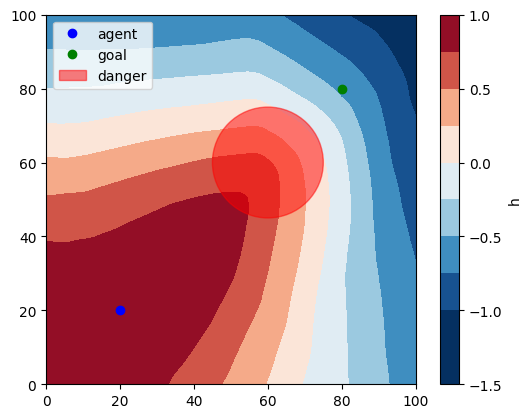

In [28]:
"""Plot the NCBF against agent position."""
args.contour_grid_size = 100
args.contour_levels = 8

test_ncbf(args, ncbf_model)

In [29]:
"""Use the NCBF model and QP to generate safe trajectories."""
args.rollouts = 500
args.steps_per_rollout = 50
args.render = False

qp_data = collect_qp(args, ncbf_model)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:14<00:00,  3.71it/s]


In [30]:
"""Train a NN to match the QP solutions."""
args.num_epochs = 2000
args.learning_rate = 1e-4
args.hidden_dims = [256, 128, 64, 32]

qp_model = train_qp(args, qp_data)

[9/2000] | Loss: 0.4577:   0%|          | 0/2000 [00:00<?, ?it/s]

[2000/2000] | Loss: 0.0024: 100%|██████████| 2000/2000 [00:07<00:00, 255.15it/s]


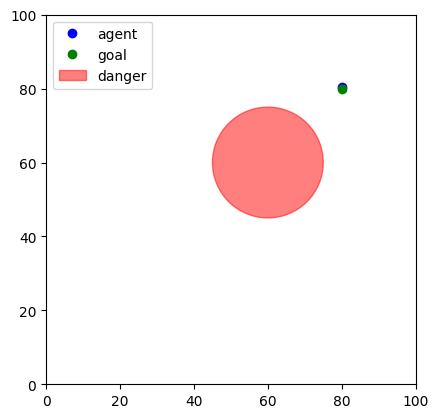

State array:
[80.11 80.41  0.    0.   80.   80.    0.    0.   60.   60.    0.    0.  ]
h: -0.5698
action: [0.01 0.02]


In [35]:
"""Render the policy using the QP model."""
args.rollouts = 3
args.steps_per_rollout = 75

_ = test_qp(args, qp_model)

To iterate on the policy, one would then take the final learned policy and use it as the nominal policy before repeating all the steps.

In [32]:
# Test the QP solver here
from pncbf.filter import QPFilter
from pncbf.state import State

s = State()
f = QPFilter(args, ncbf_model)

# Choose a custom state and nominal action
s.agent_pos = np.array([25, 25])
u_nominal = np.array([1, 1])


f(s, u_nominal)

array([ 0.  , 70.15])